In [ ]:
import yfinance as yf

# Increase historical data period to get more training samples:
# Fetch data from January 1, 2010 to January 1, 2023
data_google = yf.download("GOOGL", start="2010-01-01", end="2023-01-01")
data_google.reset_index(inplace=True)
print(data_google.head())

# Verify the DataFrame structure and columns
print("Columns:", data_google.columns)


[*********************100%***********************]  1 of 1 completed

Price                       Date  Adj Close      Close       High        Low  \
Ticker                                GOOGL      GOOGL      GOOGL      GOOGL   
0      2010-01-04 00:00:00+00:00  15.627782  15.684434  15.753504  15.621622   
1      2010-01-05 00:00:00+00:00  15.558963  15.615365  15.711712  15.554054   
2      2010-01-06 00:00:00+00:00  15.166740  15.221722  15.662162  15.174174   
3      2010-01-07 00:00:00+00:00  14.813666  14.867367  15.265265  14.831081   
4      2010-01-08 00:00:00+00:00  15.011149  15.065566  15.096346  14.742492   

Price        Open     Volume  
Ticker      GOOGL      GOOGL  
0       15.689439   78169752  
1       15.695195  120067812  
2       15.662162  158988852  
3       15.250250  256315428  
4       14.814815  188783028  
Columns: MultiIndex([(     'Date',      ''),
            ('Adj Close', 'GOOGL'),
            (    'Close', 'GOOGL'),
            (     'High', 'GOOGL'),
            (      'Low', 'GOOGL'),
            (     'Open', 'GOOGL'

In [ ]:
data_google = data_google.reset_index()
print(data_google['Date'].head())
data_google = data_google.reset_index()
data_google.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in data_google.columns]
if 'index' in data_google.columns:
    data_google = data_google.drop('index', axis=1)

# Create time index and add group identifier
data_google['time'] = range(len(data_google))
data_google['group'] = 'GOOGL'
data_google.columns

0   2010-01-04 00:00:00+00:00
1   2010-01-05 00:00:00+00:00
2   2010-01-06 00:00:00+00:00
3   2010-01-07 00:00:00+00:00
4   2010-01-08 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


Index(['level_0', 'Date', 'Adj Close_GOOGL', 'Close_GOOGL', 'High_GOOGL',
       'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL', 'time', 'group'],
      dtype='object')

In [ ]:
# --- Data Quality Improvements Begin Here ---
import pandas as pd
# Check if 'Date' is in columns; if not, reset the index again
if 'Date' not in data_google.columns:
    data_google.reset_index(inplace=True)
    print("After resetting index, columns:", data_google.columns)

# Convert 'Date' to datetime
data_google['Date'] = pd.to_datetime(data_google['Date'])

# Continue with sorting and further cleaning
data_google.sort_values('Date', inplace=True)
data_google.reset_index(drop=True, inplace=True)

# Check for missing values and fill them
print("Missing values per column:")
print(data_google.isnull().sum())
data_google.fillna(method='ffill', inplace=True)

# Remove duplicate rows
data_google.drop_duplicates(inplace=True)

# Outlier removal (example for key numerical columns)
from scipy import stats
import numpy as np
for col in ['Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL']:
    z_scores = np.abs(stats.zscore(data_google[col]))
    data_google = data_google[z_scores < 3]

# Feature engineering: Extract additional date features
data_google['year'] = data_google['Date'].dt.year
data_google['month'] = data_google['Date'].dt.month
data_google['day'] = data_google['Date'].dt.day
data_google['weekday'] = data_google['Date'].dt.weekday
data_google['month_sin'] = np.sin(2 * np.pi * data_google['month'] / 12)
data_google['month_cos'] = np.cos(2 * np.pi * data_google['month'] / 12)
data_google['weekday_sin'] = np.sin(2 * np.pi * data_google['weekday'] / 7)
data_google['weekday_cos'] = np.cos(2 * np.pi * data_google['weekday'] / 7)

# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
num_cols = ['Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL']
scaler = MinMaxScaler()
data_google[num_cols] = scaler.fit_transform(data_google[num_cols])

print("Data quality improvements complete.")
print(data_google.head())


Missing values per column:
level_0            0
Date               0
Adj Close_GOOGL    0
Close_GOOGL        0
High_GOOGL         0
Low_GOOGL          0
Open_GOOGL         0
Volume_GOOGL       0
time               0
group              0
dtype: int64
Data quality improvements complete.
   level_0                      Date  Adj Close_GOOGL  Close_GOOGL  \
0        0 2010-01-04 00:00:00+00:00        15.627782     0.034348   
1        1 2010-01-05 00:00:00+00:00        15.558963     0.033850   
2        2 2010-01-06 00:00:00+00:00        15.166740     0.031017   
4        4 2010-01-08 00:00:00+00:00        15.011149     0.029893   
6        6 2010-01-12 00:00:00+00:00        14.723404     0.027814   

   High_GOOGL  Low_GOOGL  Open_GOOGL  Volume_GOOGL  time  group  year  month  \
0    0.033353   0.034553    0.033652      0.354680     0  GOOGL  2010      1   
1    0.033056   0.034064    0.033693      0.570494     1  GOOGL  2010      1   
2    0.032703   0.031312    0.033457      0.770972   

C:\Users\deepa\AppData\Local\Temp\ipykernel_17900\2683719975.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_google.fillna(method='ffill', inplace=True)


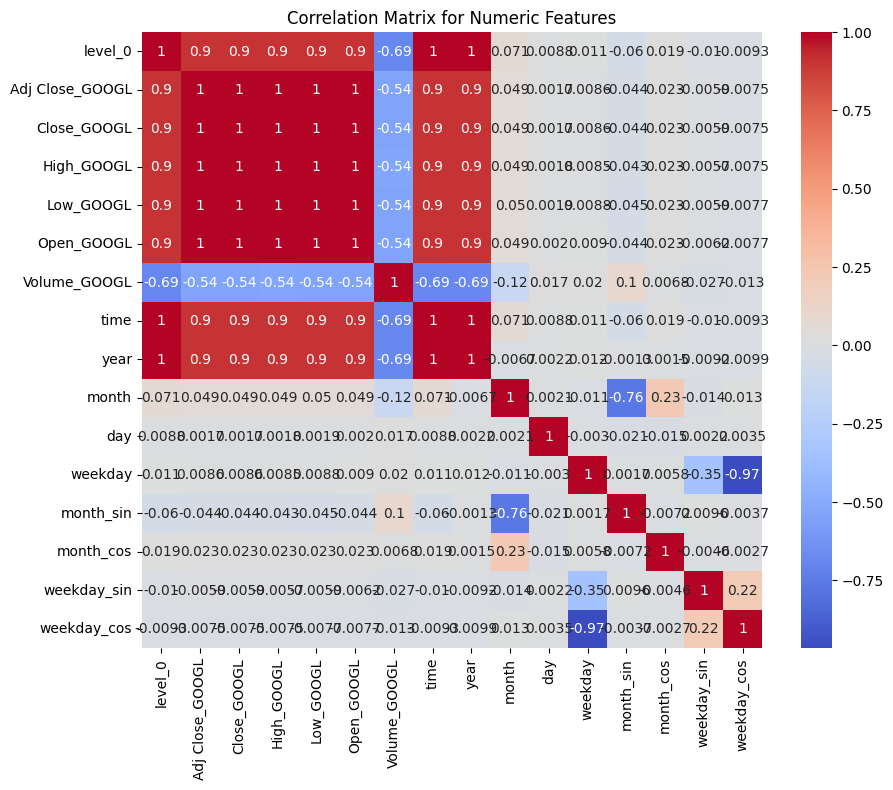

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_data = data_google.select_dtypes(include=[float, int])

# Compute the correlation matrix for numeric features
corr_matrix = numeric_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()


In [37]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
# Adjust feature_cols as needed, for example including engineered date features
X = data_google[['High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL', 'year', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']]
y = data_google['Close_GOOGL']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Lasso with cross-validation to perform feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Examine coefficients
feature_importance = pd.Series(lasso.coef_, index=X.columns)
print("Lasso coefficients:\n", feature_importance)


Lasso coefficients:
 High_GOOGL      0.796621
Low_GOOGL       0.139437
Open_GOOGL      0.000000
Volume_GOOGL    0.000000
year            0.003943
month_sin      -0.000000
month_cos       0.000000
weekday_sin     0.000000
weekday_cos     0.000000
dtype: float64


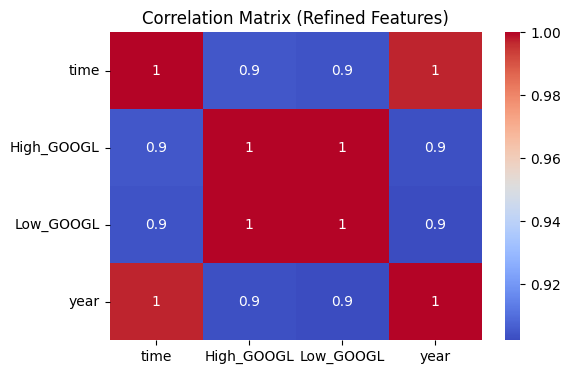

In [38]:
# Create a refined DataFrame with only the significant features:
selected_features = ['High_GOOGL', 'Low_GOOGL', 'year']  # Add any additional features if needed
refined_data = data_google[['Date', 'time', 'group'] + selected_features].copy()

# Optionally, if you want to keep some engineered date features (if they add value):
# refined_data = data_google[['Date', 'time', 'group', 'High_GOOGL', 'Low_GOOGL', 'year', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']]
import seaborn as sns
import matplotlib.pyplot as plt

numeric_refined = refined_data.select_dtypes(include=[float, int])
corr_matrix_refined = numeric_refined.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_refined, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Refined Features)")
plt.show()


In [39]:
# Create a refined DataFrame with selected features:
selected_features = ['High_GOOGL', 'Low_GOOGL', 'year']
refined_data = data_google[['Date', 'time', 'group', 'Close_GOOGL'] + selected_features].copy()

# (Assuming the earlier cells already created the 'time', 'group', and 'year' features.)
# If not, ensure that in your preprocessing you generate these columns.

from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

# Define the maximum encoder and prediction lengths
max_encoder_length = 120  # Use the past 120 days as input for each training sample
max_prediction_length = 30  # Predict the next 30 days

# Determine the training cutoff point ensuring each training sample has a full prediction window
training_cutoff = refined_data["time"].max() - max_prediction_length

# Create the TimeSeriesDataSet; with more historical data, the sliding window will yield more training samples.
training_dataset = TimeSeriesDataSet(
    refined_data[refined_data["time"] <= training_cutoff],
    time_idx="time",
    target="Close_GOOGL",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    static_reals=["year"],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=["time"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["High_GOOGL", "Low_GOOGL", "Close_GOOGL"],
    target_normalizer=GroupNormalizer(
        groups=["group"],
        transformation="softplus"  # Adjust the transformation as needed
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True  # Allows missing timesteps if necessary
)

# Create the validation dataset from the full refined data (set predict=True and stop randomization)
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    refined_data, 
    predict=True, 
    stop_randomization=True
)

# Create dataloaders
batch_size = 128  # Adjust based on your hardware capabilities
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [40]:
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
import lightning.pytorch as pl
import torch

# Initialize the TFT model with tuned hyperparameters for improved performance
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.001,          # Lower learning rate for finer convergence
    hidden_size=128,              # Increased hidden size for higher model capacity
    attention_head_size=8,        # More attention heads to capture complex dependencies
    dropout=0.5,                  # Higher dropout to reduce overfitting
    hidden_continuous_size=64,    # Increased size for continuous variable processing
    loss=QuantileLoss(),          # Using QuantileLoss (standard for TFT forecasting)
    optimizer="adam",             # You may experiment with optimizers (e.g., Ranger) if desired
    reduce_on_plateau_patience=2, # Reduce learning rate sooner if validation loss plateaus
    weight_decay=1e-3             # Added L2 regularization to combat overfitting
)

# Print the model size (optional)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

# Set up PyTorch Lightning trainer with GPU support
trainer = pl.Trainer(
    max_epochs=100,  # Increase epochs to allow for more training (early stopping can be added if needed)
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Use GPU if available
    devices=1,       # Use 1 GPU
    gradient_clip_val=0.5,  # Clip gradients to avoid explosion
    # Optionally, you can add callbacks (e.g., EarlyStopping, LearningRateMonitor) here
)

# Train the model
trainer.fit(tft, train_dataloader, val_dataloader)


c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | Quant

Number of parameters in network: 1103.7k
                                                                           

c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 23/23 [00:11<00:00,  2.01it/s, v_num=50, train_loss_step=0.012, val_loss=0.0196, train_loss_epoch=0.0119]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 23/23 [00:11<00:00,  1.95it/s, v_num=50, train_loss_step=0.012, val_loss=0.0196, train_loss_epoch=0.0119]
